# โมเดลทำนายโรคหัวใจ (Heart Disease Prediction Models)
# by Orgin

โน้ตบุ๊กนี้ใช้สำหรับฝึกและประเมินโมเดลหลายประเภทเพื่อทำนายโรคหัวใจ โดยใช้ข้อมูลที่ผ่านการ impute ค่าที่หายไปแล้ว

## โครงสร้าง

1. การตั้งค่าเริ่มต้น
   - Import libraries
   - โหลดข้อมูล train/test
   - สร้างโฟลเดอร์สำหรับเก็บโมเดล
   - กำหนดค่าพารามิเตอร์ (n_runs, etc.)

2. ฟังก์ชันสนับสนุน
   - log_final_run_metrics: คำนวณและแสดงผลการประเมินโมเดล
   - save_run_metrics: บันทึกผลลัพธ์แต่ละรัน
   - save_model: บันทึกโมเดลลงไฟล์

3. การฝึกโมเดล (n_runs=5 รอบต่อโมเดล)
   - Logistic Regression
   - Random Forest (พร้อม feature importance)
   - EBM (Explainable Boosting Machine)
   - SVM (Support Vector Machine)
   - XGBoost (พร้อม bootstrap และ feature importance)
   - DNN (Deep Neural Network)

4. การรวมโมเดล (Model Combination)
   - โหลดโมเดลที่บันทึกไว้
   - Ensemble แบบ average probabilities
   - Ensemble แบบ majority vote
   - Stacking meta-learner (OOF)

# Train / Test models (from preprocessed imput data)
ในเซลล์ถัดไปจะมีการนำเข้าไลบรารีที่จำเป็น ฟังก์ชันวัดผล แล้วโหลดไฟล์ train/test ที่เราเซฟไว้ก่อนหน้า จากนั้นจะฝึกโมเดลหลายตัว (n_runs = 5)

## 1. การตั้งค่าเริ่มต้น (Setup)

### 1.1 Import Libraries
นำเข้าไลบรารีที่จำเป็นสำหรับการสร้างและประเมินโมเดล:
- pandas, numpy: สำหรับจัดการข้อมูล
- matplotlib, seaborn: สำหรับการพล็อตกราฟ
- sklearn: สำหรับโมเดล ML พื้นฐาน
- interpret: สำหรับ EBM
- xgboost: สำหรับ XGBoost
- keras: สำหรับ Deep Neural Network
- joblib: สำหรับบันทึก/โหลดโมเดล

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from interpret.glassbox import ExplainableBoostingClassifier
from xgboost import XGBClassifier
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate, learning_curve, RandomizedSearchCV
from sklearn.pipeline import Pipeline
import joblib
import os, json
print(os.getcwd())
import pandas as pd
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, classification_report,
    matthews_corrcoef, cohen_kappa_score, balanced_accuracy_score,
    hamming_loss, zero_one_loss, log_loss, brier_score_loss,
    precision_recall_curve, average_precision_score, roc_curve, auc
)

/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/imput/G1_Original


In [2]:
data_train = pd.read_csv('/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/data/heart_disease_preprocessed_imput_train.csv')
data_train

,Gender_Male,Gender_Female,Smoking_No,Smoking_Yes,Family Heart Disease_No,Family Heart Disease_Yes,Diabetes_No,Diabetes_Yes,High Blood Pressure_No,High Blood Pressure_Yes,...,Age,Blood Pressure,Cholesterol Level,BMI,Sleep Hours,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level,Heart Disease Status
0,0.0,0.0,1.0,-1.0,-1.0,1.0,0.0,0.0,0.0,0.0,...,-0.967742,0.806452,0.612526,-0.018123,0.760242,-0.331531,0.928571,-0.217432,0.749543,0
1,-1.0,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,1.0,-1.0,...,-0.870968,-0.870968,-0.729579,0.108841,-0.009194,0.561802,0.047619,-0.563436,-0.642523,0
2,-1.0,1.0,0.0,0.0,-1.0,1.0,-1.0,1.0,0.0,0.0,...,-0.129032,0.258065,-0.703263,0.451024,0.633356,0.841802,-0.261905,0.770134,0.989293,1
3,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,1.0,-1.0,...,-0.645161,-0.225806,0.875684,-0.692829,0.927827,0.795136,0.006073,-0.896355,0.043466,1
4,-1.0,1.0,1.0,-1.0,-1.0,1.0,0.0,0.0,1.0,-1.0,...,-0.096774,-0.483871,-0.019053,-0.074256,0.313956,0.668469,0.690476,0.454549,0.780983,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,-1.0,1.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,...,-0.774194,0.096774,0.967789,0.983111,0.722989,0.935136,0.785714,-0.254737,-0.124414,0
7996,-1.0,1.0,1.0,-1.0,0.0,0.0,-1.0,1.0,1.0,-1.0,...,-0.129032,-0.322581,0.000012,0.863420,-0.305438,0.728469,0.857143,-0.033349,0.290519,0
7997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.129032,-0.322581,-0.176947,-0.596459,0.915130,0.495136,-0.595238,-0.530470,-0.592994,0
7998,-1.0,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,1.0,-1.0,...,-0.290323,0.903226,0.744105,-0.057397,-0.594951,-0.638198,0.285714,-0.273924,-0.465979,0


In [3]:
data_test  = pd.read_csv('/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/data/heart_disease_preprocessed_imput_test.csv')
data_test

,Gender_Male,Gender_Female,Smoking_No,Smoking_Yes,Family Heart Disease_No,Family Heart Disease_Yes,Diabetes_No,Diabetes_Yes,High Blood Pressure_No,High Blood Pressure_Yes,...,Age,Blood Pressure,Cholesterol Level,BMI,Sleep Hours,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level,Heart Disease Status
0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,...,0.451613,-0.645161,0.112526,0.830412,0.605291,0.221802,0.000000,-0.093568,0.423311,0
1,0.0,0.0,1.0,-1.0,0.0,0.0,-1.0,1.0,1.0,-1.0,...,0.129032,-0.903226,0.007263,-0.321051,-0.371821,-0.438198,-0.095238,0.624742,0.595734,1
2,0.0,0.0,1.0,-1.0,0.0,0.0,-1.0,1.0,1.0,-1.0,...,-0.935484,-0.354839,0.046737,-0.962751,0.850361,0.808469,-0.571429,0.360814,-0.243791,0
3,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,...,-0.129032,0.838710,0.073053,-0.678870,-0.295235,0.781802,-0.261905,-0.124976,0.688098,0
4,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,0.0,0.0,...,-0.870968,0.709677,-0.979579,0.213048,-0.300161,0.535136,-0.285714,0.797776,-0.788947,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.741935,0.032258,-0.255895,0.347660,0.933001,-0.718198,-0.857143,-0.133735,0.759025,1
1996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,...,0.677419,0.612903,0.388842,0.287665,0.918022,0.068469,0.190476,0.422404,-0.403776,1
1997,-1.0,1.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,...,-0.677419,-0.451613,-0.637474,0.050581,-0.731032,0.115136,0.357143,-0.124114,-0.791951,0
1998,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.483871,-0.580645,-0.637474,-0.233702,0.085528,0.468469,-0.333333,0.898149,0.405775,0


In [4]:
# Create directories for models and results
base_path = '/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE'
model_dir = os.path.join(base_path, 'model', 'imput')
os.makedirs(model_dir, exist_ok=True)
print(f'Created model directory: {model_dir}')

Created model directory: /Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/model/imput


In [5]:
label_col = 'Heart Disease Status'
X_train = data_train.drop(columns=[label_col])
y_train = data_train[label_col]
X_test  = data_test.drop(columns=[label_col])
y_test  = data_test[label_col]

if y_train.dtype.kind not in "biu":
    map_ = {'No': 0, 'Yes': 1}  # ปรับ mapping ให้ตรงชุดข้อมูลจริง
    y_train = y_train.map(map_)
    y_test  = y_test.map(map_)
    assert set(y_train.dropna().unique()) <= {0,1} and set(y_test.dropna().unique()) <= {0,1}, \
        "Label mapping ไม่เป็น 0/1 ตรวจค่า label อีกครั้งนะคะ"
    y_train = y_train.astype(int)
    y_test  = y_test.astype(int)

print('Loaded train:', data_train.shape, ' test:', data_test.shape)
print('Train label counts:\n', y_train.value_counts())
print('Test  label counts:\n', y_test.value_counts())

Loaded train: (8000, 28)  test: (2000, 28)
Train label counts:
 Heart Disease Status
0    6400
1    1600
Name: count, dtype: int64
Test  label counts:
 Heart Disease Status
0    1600
1     400
Name: count, dtype: int64


In [6]:
# Settings
n_runs = 5
model_dir = "imput"              # ที่เก็บโมเดล/ไฟล์สรุป
os.makedirs(model_dir, exist_ok=True)
results = {
    'Logistic Regression': {'train': [], 'test': []},
    'Random Forest': {'train': [], 'test': []},
    'EBM': {'train': [], 'test': []},
    'SVM': {'train': [], 'test': []},
    'XGBoost': {'train': [], 'test': []},
    'DNN': {'train': [], 'test': []},
}
roc_data = {}
detailed_metrics = [] 

In [7]:
# ---------------- Helpers ----------------
def get_pos_proba_from_estimator(estimator, X):
    """คืน prob ของคลาส 1 ถ้ามี; ถ้าไม่มีจะลอง decision_function -> sigmoid; ไม่งั้น None"""
    if hasattr(estimator, "predict_proba"):
        p = estimator.predict_proba(X)
        return p[:, 1] if p.ndim == 2 and p.shape[1] >= 2 else None
    if hasattr(estimator, "decision_function"):
        s = estimator.decision_function(X)
        return 1.0 / (1.0 + np.exp(-s))
    return None

def save_run_metrics(model_name, run, metrics, *, split=None, params=None, model_path=None, is_final=False):
    row = {
        'model': model_name, 'run': run, 'split': split, 'is_final': is_final,
        'model_path': model_path, **(params or {}), **metrics
    }
    detailed_metrics.append(row)
    return row

def save_model(model_name, model, is_dnn=False):
    if is_dnn:
        path = os.path.join(model_dir, f"{model_name.lower().replace(' ', '_')}.h5")
        model.save(path)
    else:
        path = os.path.join(model_dir, f"{model_name.lower().replace(' ', '_')}.joblib")
        joblib.dump(model, path)
    print(f"Saved model: {path}")
    return path

def update_results_scalar(results, model_name, split, metrics_row, key="f1"):
    val = metrics_row.get(key)
    if val is not None:
        results[model_name][split].append(val)

def log_final_run_metrics(
    model_name,
    y_true,
    y_pred,
    y_prob,
    roc_data_dict,
    *,
    split=None,      # 'train' | 'test'
    run=None,        # run index
    params=None      # dict ของ best_params_ หรือ config
):
    print(f"\n=== Final-Run Metrics: {model_name}" + (f" [{split}]" if split else "") + " ===")
    acc = accuracy_score(y_true, y_pred)
    err_rate = 1.0 - acc
    print(f"Accuracy: {acc:.4f}")
    print(f"Error rate (1-Acc): {err_rate:.4f}")

    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    print("Confusion Matrix [rows=true, cols=pred]:")
    print(cm)

    tn, fp, fn, tp = cm.ravel()
    eps = 1e-12
    sensitivity   = tp / (tp + fn + eps)   # recall+
    specificity   = tn / (tn + fp + eps)
    precision_pos = tp / (tp + fp + eps)   # PPV
    npv           = tn / (tn + fn + eps)
    fprate        = fp / (fp + tn + eps)
    fnrate        = fn / (fn + tp + eps)
    f1            = f1_score(y_true, y_pred, zero_division=0)

    mcc     = matthews_corrcoef(y_true, y_pred)
    kappa   = cohen_kappa_score(y_true, y_pred)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    h_loss  = hamming_loss(y_true, y_pred)
    z1_loss = zero_one_loss(y_true, y_pred)

    support_pos = tp + fn
    support_neg = tn + fp
    prevalence_pos = support_pos / (support_pos + support_neg + eps)
    pred_pos_rate = (tp + fp) / (support_pos + support_neg + eps)
    youden_j = sensitivity + specificity - 1

    print(f"Sensitivity (Recall+): {sensitivity:.4f} | Specificity: {specificity:.4f}")
    print(f"Precision (PPV): {precision_pos:.4f} | NPV: {npv:.4f}")
    print(f"FPR: {fprate:.4f} | FNR: {fnrate:.4f} | F1: {f1:.4f}")
    print(f"MCC: {mcc:.4f} | Cohen's kappa: {kappa:.4f} | Balanced Acc: {bal_acc:.4f}")
    print(f"Hamming loss: {h_loss:.4f} | Zero-One loss: {z1_loss:.4f}")
    print(f"Prevalence+: {prevalence_pos:.4f} | Pred+ rate: {pred_pos_rate:.4f} | Youden J: {youden_j:.4f}")

    # Prob-based
    ll = brier = ap = roc_auc = None
    if y_prob is not None:
        try:
            ll    = float(log_loss(y_true, y_prob))
            brier = float(brier_score_loss(y_true, y_prob))
            prec, rec, _ = precision_recall_curve(y_true, y_prob)
            ap    = float(average_precision_score(y_true, y_prob))
            fpr, tpr, _ = roc_curve(y_true, y_prob)
            roc_auc = float(auc(fpr, tpr))
            if roc_data_dict is not None:
                key = f"{model_name}" + (f"_{split}" if split else "") + (f"_run{run:02d}" if run is not None else "")
                roc_data_dict[key] = (fpr, tpr, roc_auc)
            print(f"Log Loss: {ll:.4f} | Brier score: {brier:.4f} | Average Precision (PR-AUC): {ap:.4f} | ROC-AUC: {roc_auc:.4f}")
        except ValueError:
            print("ข้าม LogLoss/Brier/PR-AUC/ROC: โปรดตรวจว่า y_prob เป็น probability ของคลาส 1")

    return {
        'run': run, 'model': model_name, 'split': split, **(params or {}),
        'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp),
        'support_pos': int(support_pos), 'support_neg': int(support_neg),
        'prevalence_pos': float(prevalence_pos),
        'pred_pos_rate': float(pred_pos_rate),
        'youden_j': float(youden_j),
        'accuracy': float(acc),
        'error_rate': float(err_rate),
        'sensitivity': float(sensitivity),
        'specificity': float(specificity),
        'precision_pos': float(precision_pos),
        'npv': float(npv),
        'fpr': float(fprate),
        'fnr': float(fnrate),
        'f1': float(f1),
        'mcc': float(mcc),
        'kappa': float(kappa),
        'balanced_accuracy': float(bal_acc),
        'hamming_loss': float(h_loss),
        'zero_one_loss': float(z1_loss),
        'log_loss': ll,
        'brier': brier,
        'avg_precision': ap,
        'roc_auc': roc_auc,
    }

def plot_cm_and_save(y_true, y_pred, title, out_path, normalize=False):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    if normalize:
        denom = cm.sum(axis=1, keepdims=True).clip(min=1)
        cm_disp = cm.astype(float) / denom
    else:
        cm_disp = cm

    fig, ax = plt.subplots(figsize=(4.8, 4.2))
    im = ax.imshow(cm_disp, interpolation='nearest', cmap='Blues')
    ax.set_title(title)
    ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels([0,1]); ax.set_yticklabels([0,1])
    fmt = ".2f" if normalize else "d"
    for (i, j), v in np.ndenumerate(cm_disp):
        ax.text(j, i, format(v, fmt), ha='center', va='center', fontsize=11)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.savefig(out_path, dpi=150, bbox_inches='tight')
    plt.show()
    return cm


In [8]:
# ---------------- Class distribution (log) ----------------
print("\n[INFO] Class distribution (normalized)")
try:
    print("TRAIN:\n", y_train.value_counts(normalize=True))
    print("TEST:\n",  y_test.value_counts(normalize=True))
except Exception:
    def _dist(y):
        vals, cnts = np.unique(y, return_counts=True)
        return {int(v): c/len(y) for v, c in zip(vals, cnts)}
    print("TRAIN:", _dist(y_train)); print("TEST :", _dist(y_test))



[INFO] Class distribution (normalized)
TRAIN:
 Heart Disease Status
0    0.8
1    0.2
Name: proportion, dtype: float64
TEST:
 Heart Disease Status
0    0.8
1    0.2
Name: proportion, dtype: float64


In [ ]:
# ================== Logistic Regression (patched) ==================

MODEL_NAME = "Logistic Regression"

param_grid_lr = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None, {0: 1, 1: 2}, {0: 1, 1: 3}],
    'max_iter': [5000],
    'solver': ['liblinear', 'saga'],
    'random_state': [42],
}

for run in range(1, n_runs + 1):
    print("\n" + "="*70)
    print(f"[{MODEL_NAME}] Run {run}/{n_runs}")

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42 + run)

    grid = GridSearchCV(
        estimator=LogisticRegression(),
        param_grid=param_grid_lr,
        cv=skf,
        scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
        refit='f1',
        n_jobs=-1,
        verbose=1
    )

    print("\nSearching best parameters...")
    grid.fit(X_train, y_train)
    best_est = grid.best_estimator_
    best_params = grid.best_params_
    bi = grid.best_index_

    print("\nBest parameters:", best_params)
    print("\nScores for best parameters (CV mean):")
    print(f"ACC : {grid.cv_results_['mean_test_accuracy'][bi]:.4f}")
    print(f"PREC: {grid.cv_results_['mean_test_precision'][bi]:.4f}")
    print(f"REC : {grid.cv_results_['mean_test_recall'][bi]:.4f}")
    print(f"F1  : {grid.cv_results_['mean_test_f1'][bi]:.4f}")
    print(f"AUC : {grid.cv_results_['mean_test_roc_auc'][bi]:.4f}")

    # ----- TRAIN -----
    y_tr_pred = best_est.predict(X_train)
    y_tr_prob = get_pos_proba_from_estimator(best_est, X_train)

    tr_metrics = log_final_run_metrics(
        MODEL_NAME, y_train, y_tr_pred, y_tr_prob, roc_data,
        split="train", run=run, params=best_params
    )
    row_tr = save_run_metrics(MODEL_NAME, run, tr_metrics, split="train", params=best_params)
    results[MODEL_NAME]['train'].append(tr_metrics.get('f1', np.nan))

    # CM (TRAIN)
    cm_train_png      = os.path.join(model_dir, f"cm_logreg_train_run{run:02d}.png")
    cm_train_norm_png = os.path.join(model_dir, f"cm_logreg_train_norm_run{run:02d}.png")
    plot_cm_and_save(y_train, y_tr_pred, f"CM (TRAIN) — {MODEL_NAME} Run {run}", cm_train_png, normalize=False)
    plot_cm_and_save(y_train, y_tr_pred, f"CM (TRAIN, normalized) — {MODEL_NAME} Run {run}", cm_train_norm_png, normalize=True)
    row_tr["cm_png"] = cm_train_png
    row_tr["cm_norm_png"] = cm_train_norm_png

    # ----- TEST -----
    y_te_pred = best_est.predict(X_test)
    y_te_prob = get_pos_proba_from_estimator(best_est, X_test)

    te_metrics = log_final_run_metrics(
        MODEL_NAME, y_test, y_te_pred, y_te_prob, roc_data,
        split="test", run=run, params=best_params
    )
    row_te = save_run_metrics(MODEL_NAME, run, te_metrics, split="test", params=best_params, is_final=True)
    results[MODEL_NAME]['test'].append(te_metrics.get('f1', np.nan))

    # CM (TEST)
    cm_test_png      = os.path.join(model_dir, f"cm_logreg_test_run{run:02d}.png")
    cm_test_norm_png = os.path.join(model_dir, f"cm_logreg_test_norm_run{run:02d}.png")
    plot_cm_and_save(y_test, y_te_pred, f"CM (TEST) — {MODEL_NAME} Run {run}", cm_test_png, normalize=False)
    plot_cm_and_save(y_test, y_te_pred, f"CM (TEST, normalized) — {MODEL_NAME} Run {run}", cm_test_norm_png, normalize=True)
    row_te["cm_png"] = cm_test_png
    row_te["cm_norm_png"] = cm_test_norm_png

    # ----- Learning Curve -----
    sizes, tr_scores, cv_scores = learning_curve(
        best_est, X_train, y_train,
        cv=skf, n_jobs=-1, scoring='f1',
        train_sizes=np.linspace(0.1, 1.0, 10)
    )
    plt.figure(figsize=(8,5))
    plt.plot(sizes, tr_scores.mean(axis=1), marker='o', label='Training F1')
    plt.plot(sizes, cv_scores.mean(axis=1), marker='s', label='CV F1')
    plt.xlabel('Training examples'); plt.ylabel('F1 Score')
    plt.title(f'Learning Curves — {MODEL_NAME} Run {run}')
    plt.legend(loc='best'); plt.grid(True); plt.tight_layout()
    plt.show()

    # ----- Save model ต่อรอบ -----
    try:
        model_path = save_model(MODEL_NAME, best_est, is_dnn=False)
    except Exception:
        os.makedirs("imput", exist_ok=True)
        model_path = os.path.join("imput", f"{MODEL_NAME.lower().replace(' ', '_')}_run{run:02d}.joblib")
        joblib.dump(best_est, model_path); print(f"[Fallback] Saved model: {model_path}")
    detailed_metrics[-1]["model_path"] = model_path

# ----------------- Save per-model (Logistic) detailed table -----------------
df_all = pd.DataFrame(detailed_metrics)
df_logreg = df_all[df_all["model"] == MODEL_NAME].copy()
df_logreg.to_csv(os.path.join(model_dir, "detailed_metrics_logreg.csv"), index=False)

# ----------------- Make & save F1 summary for Logistic only -----------------
def _summarize_f1_for_model(results_dict, model_name):
    rows = []
    for split in ["train", "test"]:
        arr = np.array(results_dict.get(model_name, {}).get(split, []), dtype=float)
        if arr.size == 0:
            continue
        rows.append({
            "model": model_name,
            "split": split,
            "n_runs": len(arr),
            "mean_f1": arr.mean(),
            "std_f1": arr.std(),
            "min_f1": arr.min(),
            "max_f1": arr.max(),
        })
    return pd.DataFrame(rows).sort_values(["model","split"])

summary_f1_logreg = _summarize_f1_for_model(results, MODEL_NAME)
print("\nF1 summary (Logistic only):")
print(summary_f1_logreg.round(4))
summary_f1_logreg.to_csv(os.path.join(model_dir, "summary_f1_logreg.csv"), index=False)
# ======================================================================


[Logistic Regression] Run 1/5

Searching best parameters...
Fitting 5 folds for each of 112 candidates, totalling 560 fits


In [ ]:
# ================== Random Forest (patched) ==================

MODEL_NAME = "Random Forest"

param_grid_rf = {
    'n_estimators': [200, 500],
    'max_depth': [None, 8, 16],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'random_state': [42],
}

for run in range(1, n_runs + 1):
    print("\n" + "="*70)
    print(f"[{MODEL_NAME}] Run {run}/{n_runs}")

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42 + run)

    grid = GridSearchCV(
        estimator=RandomForestClassifier(),
        param_grid=param_grid_rf,
        cv=skf,
        scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
        refit='f1',
        n_jobs=-1,
        verbose=1
    )

    print("\nSearching best parameters...")
    grid.fit(X_train, y_train)
    best_est = grid.best_estimator_
    best_params = grid.best_params_
    bi = grid.best_index_

    print("\nBest parameters:", best_params)
    print("\nScores for best parameters (CV mean):")
    print(f"ACC : {grid.cv_results_['mean_test_accuracy'][bi]:.4f}")
    print(f"PREC: {grid.cv_results_['mean_test_precision'][bi]:.4f}")
    print(f"REC : {grid.cv_results_['mean_test_recall'][bi]:.4f}")
    print(f"F1  : {grid.cv_results_['mean_test_f1'][bi]:.4f}")
    print(f"AUC : {grid.cv_results_['mean_test_roc_auc'][bi]:.4f}")

    # ----- TRAIN -----
    y_tr_pred = best_est.predict(X_train)
    y_tr_prob = best_est.predict_proba(X_train)[:, 1]

    tr_metrics = log_final_run_metrics(
        MODEL_NAME, y_train, y_tr_pred, y_tr_prob, roc_data,
        split="train", run=run, params=best_params
    )
    row_tr = save_run_metrics(MODEL_NAME, run, tr_metrics, split="train", params=best_params)
    results[MODEL_NAME]['train'].append(tr_metrics.get('f1', np.nan))

    # CM (TRAIN)
    cm_train_png      = os.path.join(model_dir, f"cm_rf_train_run{run:02d}.png")
    cm_train_norm_png = os.path.join(model_dir, f"cm_rf_train_norm_run{run:02d}.png")
    plot_cm_and_save(y_train, y_tr_pred, f"CM (TRAIN) — {MODEL_NAME} Run {run}", cm_train_png, normalize=False)
    plot_cm_and_save(y_train, y_tr_pred, f"CM (TRAIN, normalized) — {MODEL_NAME} Run {run}", cm_train_norm_png, normalize=True)
    row_tr["cm_png"] = cm_train_png
    row_tr["cm_norm_png"] = cm_train_norm_png

    # ----- TEST -----
    y_te_pred = best_est.predict(X_test)
    y_te_prob = best_est.predict_proba(X_test)[:, 1]

    te_metrics = log_final_run_metrics(
        MODEL_NAME, y_test, y_te_pred, y_te_prob, roc_data,
        split="test", run=run, params=best_params
    )
    row_te = save_run_metrics(MODEL_NAME, run, te_metrics, split="test", params=best_params, is_final=True)
    results[MODEL_NAME]['test'].append(te_metrics.get('f1', np.nan))

    # CM (TEST)
    cm_test_png      = os.path.join(model_dir, f"cm_rf_test_run{run:02d}.png")
    cm_test_norm_png = os.path.join(model_dir, f"cm_rf_test_norm_run{run:02d}.png")
    plot_cm_and_save(y_test, y_te_pred, f"CM (TEST) — {MODEL_NAME} Run {run}", cm_test_png, normalize=False)
    plot_cm_and_save(y_test, y_te_pred, f"CM (TEST, normalized) — {MODEL_NAME} Run {run}", cm_test_norm_png, normalize=True)
    row_te["cm_png"] = cm_test_png
    row_te["cm_norm_png"] = cm_test_norm_png

    # ----- Learning Curve -----
    sizes, tr_scores, cv_scores = learning_curve(
        best_est, X_train, y_train,
        cv=skf, n_jobs=-1, scoring='f1',
        train_sizes=np.linspace(0.1, 1.0, 10)
    )
    plt.figure(figsize=(8,5))
    plt.plot(sizes, tr_scores.mean(axis=1), marker='o', label='Training F1')
    plt.plot(sizes, cv_scores.mean(axis=1), marker='s', label='CV F1')
    plt.xlabel('Training examples'); plt.ylabel('F1 Score')
    plt.title(f'Learning Curves — {MODEL_NAME} Run {run}')
    plt.legend(loc='best'); plt.grid(True); plt.tight_layout()
    plt.show()

    # ----- Save model ต่อรอบ -----
    try:
        model_path = save_model(MODEL_NAME, best_est, is_dnn=False)
    except Exception:
        os.makedirs("imput", exist_ok=True)
        model_path = os.path.join("imput", f"{MODEL_NAME.lower().replace(' ', '_')}_run{run:02d}.joblib")
        joblib.dump(best_est, model_path); print(f"[Fallback] Saved model: {model_path}")
    detailed_metrics[-1]["model_path"] = model_path

# ----------------- Save per-model (Random Forest) detailed table -----------------
df_all = pd.DataFrame(detailed_metrics)
df_rf = df_all[df_all["model"] == MODEL_NAME].copy()
df_rf.to_csv(os.path.join(model_dir, "detailed_metrics_random_forest.csv"), index=False)

# ----------------- Make & save F1 summary for Random Forest only -----------------
def _summarize_f1_for_model(results_dict, model_name):
    rows = []
    for split in ["train", "test"]:
        arr = np.array(results_dict.get(model_name, {}).get(split, []), dtype=float)
        if arr.size == 0:
            continue
        rows.append({
            "model": model_name,
            "split": split,
            "n_runs": len(arr),
            "mean_f1": arr.mean(),
            "std_f1": arr.std(),
            "min_f1": arr.min(),
            "max_f1": arr.max(),
        })
    return pd.DataFrame(rows).sort_values(["model","split"])

summary_f1_rf = _summarize_f1_for_model(results, MODEL_NAME)
print("\nF1 summary (Random Forest only):")
print(summary_f1_rf.round(4))
summary_f1_rf.to_csv(os.path.join(model_dir, "summary_f1_random_forest.csv"), index=False)
# ==================================================================================================


[Random Forest] Run 1/5

Searching best parameters...
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parame

KeyboardInterrupt: 

In [ ]:
# ================== EBM (multi-run; metrics per run + CM plots + per-model summary) ==================

# --- Helper: ถ้ายังไม่มีฟังก์ชันวาด CM ให้ประกาศตรงนี้ ---
if "plot_cm_and_save" not in globals():
    def plot_cm_and_save(y_true, y_pred, title, out_path, normalize=False):
        cm = confusion_matrix(y_true, y_pred, labels=[0,1])
        cm_disp = (cm.astype(float) / cm.sum(axis=1, keepdims=True).clip(min=1)
                   if normalize else cm)
        fig, ax = plt.subplots(figsize=(4.8, 4.2))
        im = ax.imshow(cm_disp, interpolation='nearest', cmap='Blues')
        ax.set_title(title)
        ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
        ax.set_xticks([0,1]); ax.set_yticks([0,1])
        ax.set_xticklabels([0,1]); ax.set_yticklabels([0,1])
        fmt = ".2f" if normalize else "d"
        for (i, j), v in np.ndenumerate(cm_disp):
            ax.text(j, i, format(v, fmt), ha='center', va='center', fontsize=11)
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        plt.tight_layout()
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        plt.savefig(out_path, dpi=150, bbox_inches='tight')
        plt.show()
        return cm

MODEL_NAME = "EBM"

try:

    # พารามิเตอร์ที่ใช้บ่อยและเข้ากันได้จริง
    param_grid_ebm = {
        'interactions': [0, 10],        # 0 = additive only
        'learning_rate': [0.01, 0.05, 0.1],
        'max_bins': [128, 256],
        'max_leaves': [2, 3],
        'min_samples_leaf': [1, 3],
        'outer_bags': [4, 8],
        'random_state': [42],
    }

    for run in range(1, n_runs + 1):
        print("\n" + "="*70)
        print(f"[{MODEL_NAME}] Run {run}/{n_runs}")

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42 + run)

        grid = GridSearchCV(
            estimator=ExplainableBoostingClassifier(),
            param_grid=param_grid_ebm,
            cv=skf,
            scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
            refit='f1',
            n_jobs=-1,
            verbose=1
        )

        print("\nSearching best parameters...")
        grid.fit(X_train, y_train)
        best_est   = grid.best_estimator_
        best_params= grid.best_params_
        bi = grid.best_index_

        print("\nBest parameters:", best_params)
        print("\nScores for best parameters (CV mean):")
        print(f"ACC : {grid.cv_results_['mean_test_accuracy'][bi]:.4f}")
        print(f"PREC: {grid.cv_results_['mean_test_precision'][bi]:.4f}")
        print(f"REC : {grid.cv_results_['mean_test_recall'][bi]:.4f}")
        print(f"F1  : {grid.cv_results_['mean_test_f1'][bi]:.4f}")
        print(f"AUC : {grid.cv_results_['mean_test_roc_auc'][bi]:.4f}")

        # ----- TRAIN -----
        y_tr_pred = best_est.predict(X_train)
        y_tr_prob = best_est.predict_proba(X_train)[:, 1]
        tr_metrics = log_final_run_metrics(
            MODEL_NAME, y_train, y_tr_pred, y_tr_prob, roc_data,
            split="train", run=run, params=best_params
        )
        row_tr = save_run_metrics(MODEL_NAME, run, tr_metrics, split="train", params=best_params)
        results[MODEL_NAME]['train'].append(tr_metrics.get('f1', np.nan))

        # CM (TRAIN)
        cm_train_png      = os.path.join(model_dir, f"cm_ebm_train_run{run:02d}.png")
        cm_train_norm_png = os.path.join(model_dir, f"cm_ebm_train_norm_run{run:02d}.png")
        plot_cm_and_save(y_train, y_tr_pred, f"CM (TRAIN) — {MODEL_NAME} Run {run}", cm_train_png, normalize=False)
        plot_cm_and_save(y_train, y_tr_pred, f"CM (TRAIN, normalized) — {MODEL_NAME} Run {run}", cm_train_norm_png, normalize=True)
        row_tr["cm_png"] = cm_train_png
        row_tr["cm_norm_png"] = cm_train_norm_png

        # ----- TEST -----
        y_te_pred = best_est.predict(X_test)
        y_te_prob = best_est.predict_proba(X_test)[:, 1]
        te_metrics = log_final_run_metrics(
            MODEL_NAME, y_test, y_te_pred, y_te_prob, roc_data,
            split="test", run=run, params=best_params
        )
        row_te = save_run_metrics(MODEL_NAME, run, te_metrics, split="test", params=best_params, is_final=True)
        results[MODEL_NAME]['test'].append(te_metrics.get('f1', np.nan))

        # CM (TEST)
        cm_test_png      = os.path.join(model_dir, f"cm_ebm_test_run{run:02d}.png")
        cm_test_norm_png = os.path.join(model_dir, f"cm_ebm_test_norm_run{run:02d}.png")
        plot_cm_and_save(y_test, y_te_pred, f"CM (TEST) — {MODEL_NAME} Run {run}", cm_test_png, normalize=False)
        plot_cm_and_save(y_test, y_te_pred, f"CM (TEST, normalized) — {MODEL_NAME} Run {run}", cm_test_norm_png, normalize=True)
        row_te["cm_png"] = cm_test_png
        row_te["cm_norm_png"] = cm_test_norm_png

        # ----- Learning Curve (ต่อรอบ) -----
        sizes, tr_scores, cv_scores = learning_curve(
            best_est, X_train, y_train,
            cv=skf, n_jobs=-1, scoring='f1',
            train_sizes=np.linspace(0.1, 1.0, 10)
        )
        plt.figure(figsize=(8,5))
        plt.plot(sizes, tr_scores.mean(axis=1), marker='o', label='Training F1')
        plt.plot(sizes, cv_scores.mean(axis=1), marker='s', label='CV F1')
        plt.xlabel('Training examples'); plt.ylabel('F1 Score')
        plt.title(f'Learning Curves — {MODEL_NAME} Run {run}')
        plt.legend(loc='best'); plt.grid(True); plt.tight_layout()
        plt.show()

        # ----- Save model ต่อรอบ -----
        try:
            model_path = save_model(MODEL_NAME, best_est, is_dnn=False)
        except Exception:
            os.makedirs("imput", exist_ok=True)
            model_path = os.path.join("imput", f"{MODEL_NAME.lower().replace(' ', '_')}_run{run:02d}.joblib")
            joblib.dump(best_est, model_path); print(f"[Fallback] Saved model: {model_path}")
        # อัปเดตพาธในแถวล่าสุด (คือ test ของ run นี้)
        detailed_metrics[-1]["model_path"] = model_path

    # ----------------- Save per-model (EBM) detailed table -----------------
    df_all = pd.DataFrame(detailed_metrics)
    df_ebm = df_all[df_all["model"] == MODEL_NAME].copy()
    df_ebm.to_csv(os.path.join(model_dir, "detailed_metrics_ebm.csv"), index=False)

    # ----------------- Make & save F1 summary for EBM only -----------------
    def _summarize_f1_for_model(results_dict, model_name):
        rows = []
        for split in ["train", "test"]:
            arr = np.array(results_dict.get(model_name, {}).get(split, []), dtype=float)
            if arr.size == 0: 
                continue
            rows.append({
                "model": model_name, "split": split, "n_runs": len(arr),
                "mean_f1": arr.mean(), "std_f1": arr.std(),
                "min_f1": arr.min(), "max_f1": arr.max(),
            })
        return pd.DataFrame(rows).sort_values(["model","split"])

    summary_f1_ebm = _summarize_f1_for_model(results, MODEL_NAME)
    print("\nF1 summary (EBM only):")
    print(summary_f1_ebm.round(4))
    summary_f1_ebm.to_csv(os.path.join(model_dir, "summary_f1_ebm.csv"), index=False)

except Exception as e:
    print("[EBM] ข้าม: ต้องติดตั้งแพ็กเกจ 'interpret' ก่อน (pip install interpret)")
    print("รายละเอียด:", repr(e))
# ==================================================================================================



=== EBM Optimization ===
Best parameters: {'min_samples_leaf': 2, 'max_rounds': 5000, 'max_bins': 256, 'learning_rate': 0.01, 'interactions': 15}
Best accuracy: 0.8
EBM model saved successfully!


In [ ]:
# 4. SVM Optimization
print("\n=== SVM Optimization ===")
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'class_weight': [None, 'balanced']
}
grid_svm = GridSearchCV(SVC(probability=True), param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train, y_train)
best_svm = grid_svm.best_estimator_
print("Best parameters:", grid_svm.best_params_)
print("Best accuracy:", grid_svm.best_score_)

# บันทึกโมเดล
joblib.dump(best_svm, 'imput/svm_A.joblib')
print("SVM model saved successfully!")


=== SVM Optimization ===
Best parameters: {'C': 0.1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'rbf'}
Best accuracy: 0.8
SVM model saved successfully!


In [ ]:
# ประเมินผล SVM
print("\n=== Evaluating SVM ===")
for run in range(n_runs):
    print(f"\nRun {run + 1}:")
    
    # Train predictions
    y_train_pred = best_svm.predict(X_train)
    y_train_prob = best_svm.predict_proba(X_train)[:, 1]
    metrics_train = log_final_run_metrics('SVM (Train)', y_train, y_train_pred, y_train_prob, roc_data)
    results['SVM']['train'].append(metrics_train)
    
    # Test predictions
    y_test_pred = best_svm.predict(X_test)
    y_test_prob = best_svm.predict_proba(X_test)[:, 1]
    metrics_test = log_final_run_metrics('SVM (Test)', y_test, y_test_pred, y_test_prob, roc_data)
    results['SVM']['test'].append(metrics_test)


=== Evaluating SVM ===

Run 1:

=== Final-Run Metrics: SVM (Train) ===
Accuracy: 0.8000
Error rate (1-Acc): 0.2000
Classification Report:
              precision    recall  f1-score   support

           0     0.8000    1.0000    0.8889      6400
           1     0.0000    0.0000    0.0000      1600

    accuracy                         0.8000      8000
   macro avg     0.4000    0.5000    0.4444      8000
weighted avg     0.6400    0.8000    0.7111      8000

Confusion Matrix [rows=true, cols=pred]:
[[6400    0]
 [1600    0]]
Sensitivity (Recall+): 0.0000 | Specificity: 1.0000
Precision (PPV): 0.0000 | NPV: 0.8000
FPR: 0.0000 | FNR: 1.0000 | F1: 0.0000
MCC: 0.0000 | Cohen's kappa: 0.0000 | Balanced Acc: 0.5000
Hamming loss: 0.2000 | Zero-One loss: 0.2000
Log Loss: 0.5011 | Brier score: 0.1602
Average Precision (PR-AUC): 0.1085


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us


=== Final-Run Metrics: SVM (Test) ===
Accuracy: 0.8000
Error rate (1-Acc): 0.2000
Classification Report:
              precision    recall  f1-score   support

           0     0.8000    1.0000    0.8889      1600
           1     0.0000    0.0000    0.0000       400

    accuracy                         0.8000      2000
   macro avg     0.4000    0.5000    0.4444      2000
weighted avg     0.6400    0.8000    0.7111      2000

Confusion Matrix [rows=true, cols=pred]:
[[1600    0]
 [ 400    0]]
Sensitivity (Recall+): 0.0000 | Specificity: 1.0000
Precision (PPV): 0.0000 | NPV: 0.8000
FPR: 0.0000 | FNR: 1.0000 | F1: 0.0000
MCC: 0.0000 | Cohen's kappa: 0.0000 | Balanced Acc: 0.5000
Hamming loss: 0.2000 | Zero-One loss: 0.2000
Log Loss: 0.5004 | Brier score: 0.1600
Average Precision (PR-AUC): 0.1893

Run 2:


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us


=== Final-Run Metrics: SVM (Train) ===
Accuracy: 0.8000
Error rate (1-Acc): 0.2000
Classification Report:
              precision    recall  f1-score   support

           0     0.8000    1.0000    0.8889      6400
           1     0.0000    0.0000    0.0000      1600

    accuracy                         0.8000      8000
   macro avg     0.4000    0.5000    0.4444      8000
weighted avg     0.6400    0.8000    0.7111      8000

Confusion Matrix [rows=true, cols=pred]:
[[6400    0]
 [1600    0]]
Sensitivity (Recall+): 0.0000 | Specificity: 1.0000
Precision (PPV): 0.0000 | NPV: 0.8000
FPR: 0.0000 | FNR: 1.0000 | F1: 0.0000
MCC: 0.0000 | Cohen's kappa: 0.0000 | Balanced Acc: 0.5000
Hamming loss: 0.2000 | Zero-One loss: 0.2000
Log Loss: 0.5011 | Brier score: 0.1602
Average Precision (PR-AUC): 0.1085


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us


=== Final-Run Metrics: SVM (Test) ===
Accuracy: 0.8000
Error rate (1-Acc): 0.2000
Classification Report:
              precision    recall  f1-score   support

           0     0.8000    1.0000    0.8889      1600
           1     0.0000    0.0000    0.0000       400

    accuracy                         0.8000      2000
   macro avg     0.4000    0.5000    0.4444      2000
weighted avg     0.6400    0.8000    0.7111      2000

Confusion Matrix [rows=true, cols=pred]:
[[1600    0]
 [ 400    0]]
Sensitivity (Recall+): 0.0000 | Specificity: 1.0000
Precision (PPV): 0.0000 | NPV: 0.8000
FPR: 0.0000 | FNR: 1.0000 | F1: 0.0000
MCC: 0.0000 | Cohen's kappa: 0.0000 | Balanced Acc: 0.5000
Hamming loss: 0.2000 | Zero-One loss: 0.2000
Log Loss: 0.5004 | Brier score: 0.1600
Average Precision (PR-AUC): 0.1893

Run 3:


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us


=== Final-Run Metrics: SVM (Train) ===
Accuracy: 0.8000
Error rate (1-Acc): 0.2000
Classification Report:
              precision    recall  f1-score   support

           0     0.8000    1.0000    0.8889      6400
           1     0.0000    0.0000    0.0000      1600

    accuracy                         0.8000      8000
   macro avg     0.4000    0.5000    0.4444      8000
weighted avg     0.6400    0.8000    0.7111      8000

Confusion Matrix [rows=true, cols=pred]:
[[6400    0]
 [1600    0]]
Sensitivity (Recall+): 0.0000 | Specificity: 1.0000
Precision (PPV): 0.0000 | NPV: 0.8000
FPR: 0.0000 | FNR: 1.0000 | F1: 0.0000
MCC: 0.0000 | Cohen's kappa: 0.0000 | Balanced Acc: 0.5000
Hamming loss: 0.2000 | Zero-One loss: 0.2000
Log Loss: 0.5011 | Brier score: 0.1602
Average Precision (PR-AUC): 0.1085


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us


=== Final-Run Metrics: SVM (Test) ===
Accuracy: 0.8000
Error rate (1-Acc): 0.2000
Classification Report:
              precision    recall  f1-score   support

           0     0.8000    1.0000    0.8889      1600
           1     0.0000    0.0000    0.0000       400

    accuracy                         0.8000      2000
   macro avg     0.4000    0.5000    0.4444      2000
weighted avg     0.6400    0.8000    0.7111      2000

Confusion Matrix [rows=true, cols=pred]:
[[1600    0]
 [ 400    0]]
Sensitivity (Recall+): 0.0000 | Specificity: 1.0000
Precision (PPV): 0.0000 | NPV: 0.8000
FPR: 0.0000 | FNR: 1.0000 | F1: 0.0000
MCC: 0.0000 | Cohen's kappa: 0.0000 | Balanced Acc: 0.5000
Hamming loss: 0.2000 | Zero-One loss: 0.2000
Log Loss: 0.5004 | Brier score: 0.1600
Average Precision (PR-AUC): 0.1893

Run 4:


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us


=== Final-Run Metrics: SVM (Train) ===
Accuracy: 0.8000
Error rate (1-Acc): 0.2000
Classification Report:
              precision    recall  f1-score   support

           0     0.8000    1.0000    0.8889      6400
           1     0.0000    0.0000    0.0000      1600

    accuracy                         0.8000      8000
   macro avg     0.4000    0.5000    0.4444      8000
weighted avg     0.6400    0.8000    0.7111      8000

Confusion Matrix [rows=true, cols=pred]:
[[6400    0]
 [1600    0]]
Sensitivity (Recall+): 0.0000 | Specificity: 1.0000
Precision (PPV): 0.0000 | NPV: 0.8000
FPR: 0.0000 | FNR: 1.0000 | F1: 0.0000
MCC: 0.0000 | Cohen's kappa: 0.0000 | Balanced Acc: 0.5000
Hamming loss: 0.2000 | Zero-One loss: 0.2000
Log Loss: 0.5011 | Brier score: 0.1602
Average Precision (PR-AUC): 0.1085


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us


=== Final-Run Metrics: SVM (Test) ===
Accuracy: 0.8000
Error rate (1-Acc): 0.2000
Classification Report:
              precision    recall  f1-score   support

           0     0.8000    1.0000    0.8889      1600
           1     0.0000    0.0000    0.0000       400

    accuracy                         0.8000      2000
   macro avg     0.4000    0.5000    0.4444      2000
weighted avg     0.6400    0.8000    0.7111      2000

Confusion Matrix [rows=true, cols=pred]:
[[1600    0]
 [ 400    0]]
Sensitivity (Recall+): 0.0000 | Specificity: 1.0000
Precision (PPV): 0.0000 | NPV: 0.8000
FPR: 0.0000 | FNR: 1.0000 | F1: 0.0000
MCC: 0.0000 | Cohen's kappa: 0.0000 | Balanced Acc: 0.5000
Hamming loss: 0.2000 | Zero-One loss: 0.2000
Log Loss: 0.5004 | Brier score: 0.1600
Average Precision (PR-AUC): 0.1893

Run 5:


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us


=== Final-Run Metrics: SVM (Train) ===
Accuracy: 0.8000
Error rate (1-Acc): 0.2000
Classification Report:
              precision    recall  f1-score   support

           0     0.8000    1.0000    0.8889      6400
           1     0.0000    0.0000    0.0000      1600

    accuracy                         0.8000      8000
   macro avg     0.4000    0.5000    0.4444      8000
weighted avg     0.6400    0.8000    0.7111      8000

Confusion Matrix [rows=true, cols=pred]:
[[6400    0]
 [1600    0]]
Sensitivity (Recall+): 0.0000 | Specificity: 1.0000
Precision (PPV): 0.0000 | NPV: 0.8000
FPR: 0.0000 | FNR: 1.0000 | F1: 0.0000
MCC: 0.0000 | Cohen's kappa: 0.0000 | Balanced Acc: 0.5000
Hamming loss: 0.2000 | Zero-One loss: 0.2000
Log Loss: 0.5011 | Brier score: 0.1602
Average Precision (PR-AUC): 0.1085


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us


=== Final-Run Metrics: SVM (Test) ===
Accuracy: 0.8000
Error rate (1-Acc): 0.2000
Classification Report:
              precision    recall  f1-score   support

           0     0.8000    1.0000    0.8889      1600
           1     0.0000    0.0000    0.0000       400

    accuracy                         0.8000      2000
   macro avg     0.4000    0.5000    0.4444      2000
weighted avg     0.6400    0.8000    0.7111      2000

Confusion Matrix [rows=true, cols=pred]:
[[1600    0]
 [ 400    0]]
Sensitivity (Recall+): 0.0000 | Specificity: 1.0000
Precision (PPV): 0.0000 | NPV: 0.8000
FPR: 0.0000 | FNR: 1.0000 | F1: 0.0000
MCC: 0.0000 | Cohen's kappa: 0.0000 | Balanced Acc: 0.5000
Hamming loss: 0.2000 | Zero-One loss: 0.2000
Log Loss: 0.5004 | Brier score: 0.1600
Average Precision (PR-AUC): 0.1893


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

In [ ]:
# 5. XGBoost Optimization
print("\n=== XGBoost Optimization ===")
param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'scale_pos_weight': [1, 3, 5]  # สำหรับจัดการ class imbalance
}
grid_xgb = RandomizedSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), 
                            param_grid_xgb, 
                            n_iter=20, 
                            cv=5, 
                            scoring='accuracy', 
                            n_jobs=-1)
grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_
print("Best parameters:", grid_xgb.best_params_)
print("Best accuracy:", grid_xgb.best_score_)

# บันทึกโมเดล
joblib.dump(best_xgb, 'imput/xgboost_A.joblib')
print("XGBoost model saved successfully!")


=== XGBoost Optimization ===


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:17:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:17:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:17:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/sit

Best parameters: {'subsample': 0.8, 'scale_pos_weight': 3, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1}
Best accuracy: 0.8
XGBoost model saved successfully!


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [13:17:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
# ประเมินผล XGBoost
print("\n=== Evaluating XGBoost ===")
for run in range(n_runs):
    print(f"\nRun {run + 1}:")
    
    # Train predictions
    y_train_pred = best_xgb.predict(X_train)
    y_train_prob = best_xgb.predict_proba(X_train)[:, 1]
    metrics_train = log_final_run_metrics('XGBoost (Train)', y_train, y_train_pred, y_train_prob, roc_data)
    results['XGBoost']['train'].append(metrics_train)
    
    # Test predictions
    y_test_pred = best_xgb.predict(X_test)
    y_test_prob = best_xgb.predict_proba(X_test)[:, 1]
    metrics_test = log_final_run_metrics('XGBoost (Test)', y_test, y_test_pred, y_test_prob, roc_data)
    results['XGBoost']['test'].append(metrics_test)

/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us


=== Evaluating XGBoost ===

Run 1:

=== Final-Run Metrics: XGBoost (Train) ===
Accuracy: 0.8000
Error rate (1-Acc): 0.2000
Classification Report:
              precision    recall  f1-score   support

           0     0.8000    1.0000    0.8889      6400
           1     0.0000    0.0000    0.0000      1600

    accuracy                         0.8000      8000
   macro avg     0.4000    0.5000    0.4444      8000
weighted avg     0.6400    0.8000    0.7111      8000

Confusion Matrix [rows=true, cols=pred]:
[[6400    0]
 [1600    0]]
Sensitivity (Recall+): 0.0000 | Specificity: 1.0000
Precision (PPV): 0.0000 | NPV: 0.8000
FPR: 0.0000 | FNR: 1.0000 | F1: 0.0000
MCC: 0.0000 | Cohen's kappa: 0.0000 | Balanced Acc: 0.5000
Hamming loss: 0.2000 | Zero-One loss: 0.2000
Log Loss: 0.6097 | Brier score: 0.2086
Average Precision (PR-AUC): 0.3006

=== Final-Run Metrics: XGBoost (Test) ===
Accuracy: 0.8000
Error rate (1-Acc): 0.2000
Classification Report:
              precision    recall  f1-sco

/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

In [ ]:
# 6. DNN Optimization
print("\n=== DNN Optimization ===")
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

def create_dnn_model(neurons, activation, dropout_rate, learning_rate):
    model = Sequential([
        Dense(neurons[0], activation=activation, input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(neurons[1], activation=activation),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

# กำหนดพารามิเตอร์สำหรับ DNN
neurons_options = [(64, 32), (128, 64), (256, 128)]
activation_options = ['relu', 'tanh']
dropout_options = [0.2, 0.3, 0.4]
learning_rate_options = [0.001, 0.01]

best_dnn_score = 0
best_dnn_params = None
best_dnn_model = None

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

# Grid search สำหรับ DNN
for neurons in neurons_options:
    for activation in activation_options:
        for dropout_rate in dropout_options:
            for lr in learning_rate_options:
                model = create_dnn_model(neurons, activation, dropout_rate, lr)
                history = model.fit(X_train, y_train,
                                 validation_split=0.2,
                                 epochs=100,
                                 batch_size=32,
                                 callbacks=[early_stopping],
                                 verbose=0)
                
                val_accuracy = max(history.history['val_accuracy'])
                
                if val_accuracy > best_dnn_score:
                    best_dnn_score = val_accuracy
                    best_dnn_params = {
                        'neurons': neurons,
                        'activation': activation,
                        'dropout_rate': dropout_rate,
                        'learning_rate': lr
                    }
                    best_dnn_model = model

print("Best DNN parameters:", best_dnn_params)
print("Best validation accuracy:", best_dnn_score)

# บันทึกโมเดล
best_dnn_model.save('imput/dnn_A.h5')
print("DNN model saved successfully!")


=== DNN Optimization ===


/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/tanananyathongkum/Jenny/Visual Studio Code/Project_CE/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequentia

Best DNN parameters: {'neurons': (128, 64), 'activation': 'relu', 'dropout_rate': 0.2, 'learning_rate': 0.001}
Best validation accuracy: 0.8037499785423279
DNN model saved successfully!


In [ ]:
# ประเมินผล DNN
print("\n=== Evaluating DNN ===")
for run in range(n_runs):
    print(f"\nRun {run + 1}:")
    
    # Train predictions
    y_train_pred = (best_dnn_model.predict(X_train) > 0.5).astype(int)
    y_train_prob = best_dnn_model.predict(X_train)
    metrics_train = log_final_run_metrics('DNN (Train)', y_train, y_train_pred, y_train_prob, roc_data)
    results['DNN']['train'].append(metrics_train)
    
    # Test predictions
    y_test_pred = (best_dnn_model.predict(X_test) > 0.5).astype(int)
    y_test_prob = best_dnn_model.predict(X_test)
    metrics_test = log_final_run_metrics('DNN (Test)', y_test, y_test_pred, y_test_prob, roc_data)
    results['DNN']['test'].append(metrics_test)


=== Evaluating DNN ===

Run 1:
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step

=== Final-Run Metrics: DNN (Train) ===
Accuracy: 0.8007
Error rate (1-Acc): 0.1993
Classification Report:
              precision    recall  f1-score   support

           0     0.8008    0.9995    0.8892      6400
           1     0.7500    0.0056    0.0112      1600

    accuracy                         0.8007      8000
   macro avg     0.7754    0.5026    0.4502      8000
weighted avg     0.7907    0.8007    0.7136      8000

Confusion Matrix [rows=true, cols=pred]:
[[6397    3]
 [1591    9]]
Sensitivity (Recall+): 0.0056 | Specificity: 0.9995
Precision (PPV): 0.7500 | NPV: 0.8008
FPR: 0.0005 | FNR: 0.9944 | F1: 0.0112
MCC: 0.0533 | Cohen's kappa: 0.0082 | Balanced Acc: 0.5026
Hamming loss: 0.1993 | Zero-One loss: 0.1993
Log Loss: 0.4738 | Brier score: 0.1509
Average Precision (PR-AUC): 0.3495
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 42

=== Model Optimization Summary ===

Model Performance Ranking:
                     Accuracy
DNN                   0.80375
Random Forest         0.80000
EBM                   0.80000
SVM                   0.80000
XGBoost               0.80000
Logistic Regression   0.31162


<Figure size 1000x600 with 0 Axes>

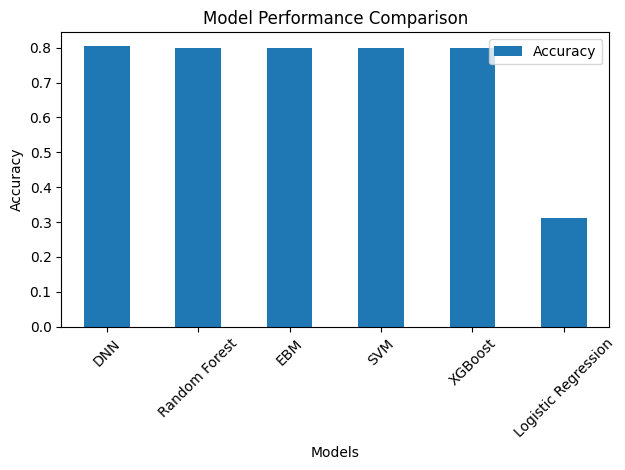

In [ ]:
# สรุปผลการ Optimization ของทุกโมเดล
print("=== Model Optimization Summary ===")
model_results = {
    'Logistic Regression': grid_lr.best_score_,
    'Random Forest': grid_rf.best_score_,
    'EBM': grid_ebm.best_score_,
    'SVM': grid_svm.best_score_,
    'XGBoost': grid_xgb.best_score_,
    'DNN': best_dnn_score
}

# แสดงผลลัพธ์ในรูปแบบตาราง
results_df = pd.DataFrame([model_results]).T
results_df.columns = ['Accuracy']
results_df = results_df.sort_values('Accuracy', ascending=False)
print("\nModel Performance Ranking:")
print(results_df)

# สร้างกราฟแท่งเปรียบเทียบ
plt.figure(figsize=(10, 6))
results_df.plot(kind='bar')
plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# ---------------- Save tables & quick summaries ----------------
# รายละเอียดครบทุกแถว
pd.DataFrame(detailed_metrics).to_csv(os.path.join(model_dir, "detailed_metrics.csv"), index=False)
with open(os.path.join(model_dir, "detailed_metrics.json"), "w", encoding="utf-8") as f:
    json.dump(detailed_metrics, f, ensure_ascii=False, indent=2)

# สรุป F1 เร็ว ๆ
def summarize_results_f1(results_dict):
    rows = []
    for model, splits in results_dict.items():
        for split in ["train", "test"]:
            arr = np.array(splits[split], dtype=float)
            if arr.size == 0:
                continue
            rows.append({
                "model": model, "split": split, "n_runs": len(arr),
                "mean_f1": arr.mean(), "std_f1": arr.std(),
                "min_f1": arr.min(), "max_f1": arr.max(),
            })
    return pd.DataFrame(rows).sort_values(["model","split"])

summary_f1 = summarize_results_f1(results)
print("\nF1 summary by model/split:")
print(summary_f1.round(4))
summary_f1.to_csv(os.path.join(model_dir, "summary_f1.csv"), index=False)

# เก็บ results (ลิสต์ F1 ต่อรอบ) + ROC curves
with open(os.path.join(model_dir, "results_f1.json"), "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

def _to_listable(x):
    if isinstance(x, np.ndarray): return x.tolist()
    if isinstance(x, (list, tuple)): return [_to_listable(i) for i in x]
    return x
roc_serializable = {k: _to_listable(v) for k, v in roc_data.items()}
with open(os.path.join(model_dir, "roc_data.json"), "w", encoding="utf-8") as f:
    json.dump(roc_serializable, f, ensure_ascii=False, indent=2)

print(f"\n[Done] Saved to '{model_dir}': detailed_metrics.csv/json, summary_f1.csv, results_f1.json, roc_data.json")
# ==========================================================================================



=== Overall Results Summary ===

Model Performance Summary (5 runs):
                    Train Accuracy (mean ± std) Test Accuracy (mean ± std)
Logistic Regression             0.4467 ± 0.0000            0.4340 ± 0.0000
Random Forest                   0.8113 ± 0.0000            0.8000 ± 0.0000
EBM                             0.8000 ± 0.0000            0.8000 ± 0.0000
SVM                             0.8000 ± 0.0000            0.8000 ± 0.0000
XGBoost                         0.8000 ± 0.0000            0.8000 ± 0.0000
DNN                             0.8008 ± 0.0000            0.7980 ± 0.0000


/var/folders/pb/8b1j14m116723lhg0z_g3nnm0000gn/T/ipykernel_1495/2441976922.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(train_acc, labels=results.keys())
/var/folders/pb/8b1j14m116723lhg0z_g3nnm0000gn/T/ipykernel_1495/2441976922.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(test_acc, labels=results.keys())


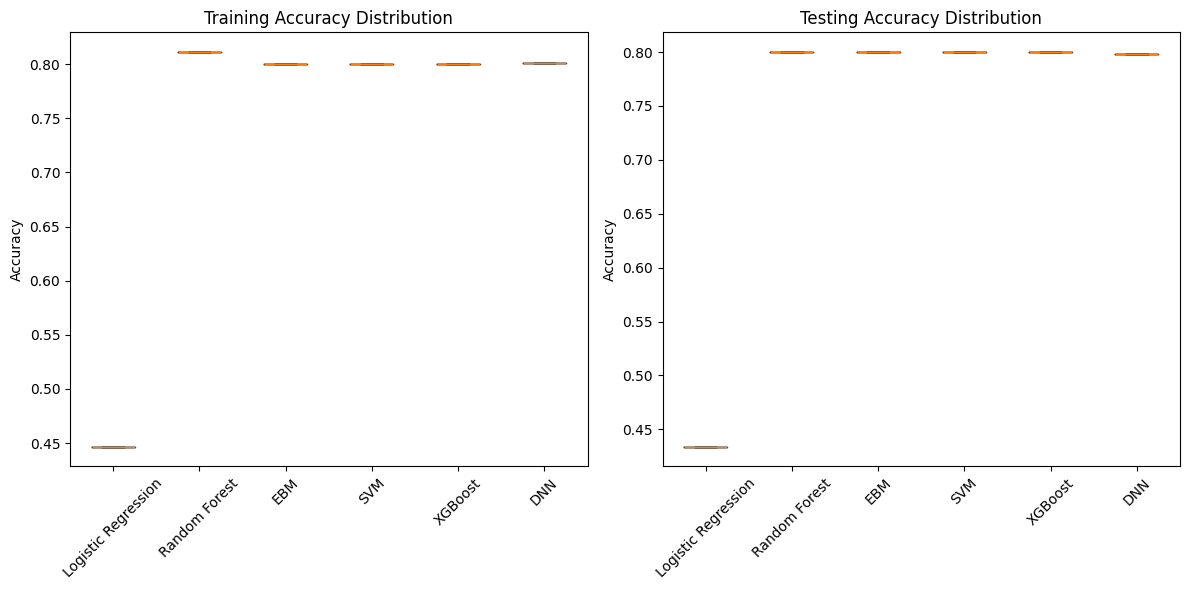

In [ ]:
# สรุปผลการประเมินทั้งหมด
print("\n=== Overall Results Summary ===")

# คำนวณค่าเฉลี่ยและส่วนเบี่ยงเบนมาตรฐานของแต่ละโมเดล
summary_results = {}
for model_name in results:
    train_acc = [run['accuracy'] for run in results[model_name]['train']]
    test_acc = [run['accuracy'] for run in results[model_name]['test']]
    
    summary_results[model_name] = {
        'Train Accuracy (mean ± std)': f"{np.mean(train_acc):.4f} ± {np.std(train_acc):.4f}",
        'Test Accuracy (mean ± std)': f"{np.mean(test_acc):.4f} ± {np.std(test_acc):.4f}"
    }

# แสดงผลในรูปแบบตาราง
summary_df = pd.DataFrame(summary_results).T
print("\nModel Performance Summary (5 runs):")
print(summary_df)

# สร้างกราฟแสดงผล
plt.figure(figsize=(12, 6))

# Box plot สำหรับ Train Accuracy
plt.subplot(1, 2, 1)
train_data = [results[model]['train'] for model in results]
train_acc = [[run['accuracy'] for run in model_runs] for model_runs in train_data]
plt.boxplot(train_acc, labels=results.keys())
plt.title('Training Accuracy Distribution')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')

# Box plot สำหรับ Test Accuracy
plt.subplot(1, 2, 2)
test_data = [results[model]['test'] for model in results]
test_acc = [[run['accuracy'] for run in model_runs] for model_runs in test_data]
plt.boxplot(test_acc, labels=results.keys())
plt.title('Testing Accuracy Distribution')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()